Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.<br>
Mobile Games AB Testing with Cookie Cats

In [64]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from scipy.stats import ttest_1samp
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from scipy.stats import kstest

In [65]:
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

In [66]:
data = pd.read_excel('AB result.xlsx')

In [67]:
data.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,0,0
1,337,gate_30,38,1,0
2,377,gate_40,165,1,0
3,483,gate_40,1,0,0
4,488,gate_40,179,1,1


In [68]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  int64 
 4   retention_7     90189 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 3.4+ MB


In [69]:
data.describe()

,userid,sum_gamerounds,retention_1,retention_7
count,9.018900e+04,90189.000000,90189.000000,90189.000000
mean,4.998412e+06,51.872457,0.445210,0.186065
std,2.883286e+06,195.050858,0.496992,0.389161
min,1.160000e+02,0.000000,0.000000,0.000000
25%,2.512230e+06,5.000000,0.000000,0.000000
50%,4.995815e+06,16.000000,0.000000,0.000000
75%,7.496452e+06,51.000000,1.000000,0.000000
max,9.999861e+06,49854.000000,1.000000,1.000000


In [70]:
data.version.unique()

array(['gate_30', 'gate_40'], dtype=object)

In [71]:
data.nlargest(5, ['sum_gamerounds'])

,userid,version,sum_gamerounds,retention_1,retention_7
57702,6390605,gate_30,49854,0,1
7912,871500,gate_30,2961,1,1
29417,3271615,gate_40,2640,1,0
43671,4832608,gate_30,2438,1,1
48188,5346171,gate_40,2294,1,1


In [72]:
data = data[data.sum_gamerounds < 3000]

In [73]:
data.describe()

,userid,sum_gamerounds,retention_1,retention_7
count,9.018800e+04,90188.000000,90188.000000,90188.000000
mean,4.998397e+06,51.320253,0.445214,0.186056
std,2.883298e+06,102.682719,0.496992,0.389154
min,1.160000e+02,0.000000,0.000000,0.000000
25%,2.512211e+06,5.000000,0.000000,0.000000
50%,4.995804e+06,16.000000,0.000000,0.000000
75%,7.496461e+06,51.000000,1.000000,0.000000
max,9.999861e+06,2961.000000,1.000000,1.000000


In [74]:
# Определим размеры выборок для проверки, что сравнение статистически обосновано.
# Сравним версии gate_30 и gate_40.
A = data.version.groupby(data.version == 'gate_30').count()
B = data.version.groupby(data.version == 'gate_40').count()
A, B

(version
 False    45489
 True     44699
 Name: version, dtype: int64,
 version
 False    44699
 True     45489
 Name: version, dtype: int64)

Число версий примерно одинаковы.<br>
Версия gate_30 - контрольная группа A.<br>
Версия gate_40 - контрольная группа B.

In [75]:
mannwhitneyu(data[data.version == 'gate_30'].sum_gamerounds,
             data[data.version == 'gate_40'].sum_gamerounds)

MannwhitneyuResult(statistic=1024285761.5, pvalue=0.05089155279145376)

pvalue немного более 0.05 соответственно проведение теста будет не достаточно для принятия решения.

In [76]:

ttest_ind(data[data.version == 'gate_30'].sum_gamerounds,
          data[data.version == 'gate_40'].sum_gamerounds)

Ttest_indResult(statistic=0.0633675766982082, pvalue=0.9494739458256001)

In [77]:
print(kstest(data['sum_gamerounds'][data.version == 'gate_30'], 'norm'))
print(kstest(data['sum_gamerounds'][data.version == 'gate_40'], 'norm'))

KstestResult(statistic=0.8724153079945488, pvalue=0.0, statistic_location=2, statistic_sign=-1)
KstestResult(statistic=0.8707186187388001, pvalue=0.0, statistic_location=2, statistic_sign=-1)


Распределение не нормальное.

Text(0.5, 1.0, 'Number of game rounds players on the first week')

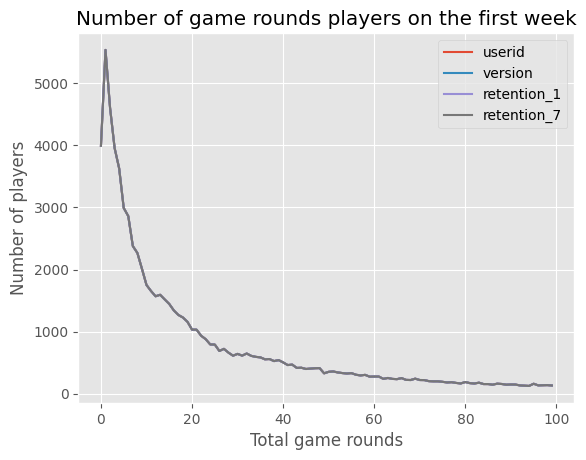

In [78]:
# Поиск пользователей
plot_data = data.groupby('sum_gamerounds').count()

ax = plot_data[:100].plot()
ax.set_xlabel('Total game rounds')
ax.set_ylabel('Number of players')
ax.set_title('Number of game rounds players on the first week')

Согласно данным большее число пользователей игарет около 20 раундов.

Для получения активности пользователей неоходимо распределить выборки.<br>
Гистограммный график различных распределений групп АВ.

In [79]:
plt.style.use('ggplot')

Group_A = data[data.version == 'gate_30']
print(Group_A.head())

Group_B = data[data.version == 'gate_40']
print(Group_B.head())

bins = [0, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 500]
plot_GA = pd.DataFrame(Group_A.groupby(pd.cut(Group_A['sum_gamerounds'],
                                              bins=bins)).count())
plot_GB = pd.DataFrame(Group_B.groupby(pd.cut(Group_B['sum_gamerounds'],
                                              bins=bins)).count())

    userid  version  sum_gamerounds  retention_1  retention_7
0      116  gate_30               3            0            0
1      337  gate_30              38            1            0
6     1066  gate_30               0            0            0
11    2101  gate_30               0            0            0
13    2179  gate_30              39            1            0
   userid  version  sum_gamerounds  retention_1  retention_7
2     377  gate_40             165            1            0
3     483  gate_40               1            0            0
4     488  gate_40             179            1            1
5     540  gate_40             187            1            1
7    1444  gate_40               2            0            0


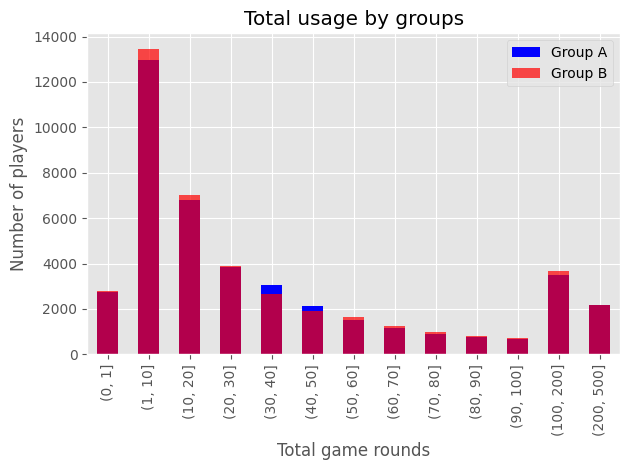

In [80]:
ax = plot_GA.plot(kind = 'bar', y='userid', color = 'blue', alpha = 1,
                  title = 'Total usage by groups')
plot_GB.plot(kind = 'bar', y = 'userid', ax = ax, color = 'red', alpha = 0.7)
ax.set_xlabel('Total game rounds')
ax.set_ylabel('Number of players')
plt.legend(['Group A', 'Group B'])
plt.tight_layout()
plt.grid(True)

Согласно графику имеются небольшие различия.<br>
Наиболее значимые различие отмечаются в позициях 30, 40 и 40, 50  

In [81]:
# Определение удержания в течении 1 дня
oneday = data.retention_1.sum()/data.retention_1.count()
print(str(oneday*100)+'%')

44.521444094558035%


In [82]:
# Определение удержания в течении 1 дня для каждой из групп
oneday = data.retention_1.groupby(data.version).sum()/data.retention_1.groupby(data.version).count()
print(oneday*100)

version
gate_30    44.819795
gate_40    44.228275
Name: retention_1, dtype: float64


Различия минимальны. Явного ответа для начала проведения теста не получены. Для принятия решения необходимо воспользоваться Bootstrapp в целях детального исследования.

In [83]:
boot_1d = []
for i in range(500):
    boot_mean = data.retention_1.sample(frac=1, replace=True).groupby(data.version).mean()
    boot_1d.append(boot_mean)

boot_1d = data.DataFrame(boot_1d)
print(boot_1d)

AttributeError: 'DataFrame' object has no attribute 'DataFrame'

In [84]:
ax = boot_1d.plot.kde()
ax.set_title('The average of 1-day retention for each AB group')
ax.set_xlabel('The average of 1-day retention')

AttributeError: 'list' object has no attribute 'plot'